# LFC Data Analysis: The Elite Strikers

See Terry's blog [LFC: The Elite Strikers](http://terrydolan.blogspot.co.uk/2015/07/lfc-the-elite-strikers.html) for a discussion of of the data analysis.

This notebook analyses Liverpool FC's elite strikers data from 1962-1963 to 2014-2015. An elite striker is defined as a player who scored 20 or more league goals in a season. I've started the analysis at 1962 as this was when Bill Shankly returned Liverpool to the top flight of English football. The analysis uses [IPython Notebook](http://ipython.org/notebook.html), [python](https://www.python.org/), [pandas](http://pandas.pydata.org/) and [matplotlib](http://matplotlib.org/) to explore the data. 

#### Notebook Change Log

In [1]:
%%html
<! left align the change log table in next cell >
<style>
table {float:left}
</style>

| Date          | Change Description |
| :------------ | :----------------- |
| 23rd July 2015 | Initial baseline |

## Set-up

Import the modules needed for the analysis.

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sys
import collections
from datetime import datetime
from __future__ import division

# enable inline plotting
%matplotlib inline

Print version numbers.

In [3]:
print 'python version: {}'.format(sys.version)
print 'pandas version: {}'.format(pd.__version__)
print 'matplotlib version: {}'.format(mpl.__version__)
print 'numpy version: {}'.format(np.__version__)

python version: 2.7.8 |Anaconda 2.3.0 (64-bit)| (default, Jul  2 2014, 15:12:11) [MSC v.1500 64 bit (AMD64)]
pandas version: 0.16.2
matplotlib version: 1.4.3
numpy version: 1.9.2


## Load the LFC data into a dataframes and munge

#### Create dataframe of scorers in top level seasons

In [4]:
LFC_SCORERS_CSV_FILE = 'data\lfc_scorers_1892-1893_2014-2015.csv'
dflfc_scorers = pd.read_csv(LFC_SCORERS_CSV_FILE)

# sort by season, then league goals
dflfc_scorers = dflfc_scorers.sort(['season', 'league'], ascending=([False, False]))
dflfc_scorers.shape

(1398, 3)

In [5]:
dflfc_scorers.head()

,season,player,league
1382,2014-2015,Steven Gerrard,9
1383,2014-2015,Raheem Sterling,7
1385,2014-2015,Jordan Henderson,6
1384,2014-2015,Philippe Coutinho,5
1386,2014-2015,Adam Lallana,5


In [6]:
dflfc_scorers.tail()

,season,player,league
5,1892-1893,Jonathan Cameron,4
6,1892-1893,Jim McBride,4
7,1892-1893,Hugh McQueen,3
9,1892-1893,Joe McQue,2
8,1892-1893,Own goals,1


In [7]:
# note that scorers includes own goals
dflfc_scorers[dflfc_scorers.player == 'Own goals'].head()

,season,player,league
1388,2014-2015,Own goals,4
1374,2013-2014,Own goals,5
1356,2012-2013,Own goals,4
1343,2011-2012,Own goals,5
1334,2010-2011,Own goals,1


In [8]:
# note: war years already excluded
LANCS_YRS = ['1892-1893']
SECOND_DIV_YRS = ['1893-1894', '1895-1896', '1904-1905', '1961-1962', 
                  '1954-1955', '1955-1956', '1956-1957', '1957-1958', 
                  '1958-1959', '1959-1960', '1960-1961']

NOT_TOP_LEVEL_YRS = LANCS_YRS + SECOND_DIV_YRS
dflfc_scorers_tl = dflfc_scorers[~dflfc_scorers.season.isin(NOT_TOP_LEVEL_YRS)].copy()
dflfc_scorers_tl.shape

(1250, 3)

In [9]:
## check number of seasons aligns with http://www.lfchistory.net/Stats/LeagueOverall.aspx
## expect 100 total
print 'num seasons is {}'.format(len(dflfc_scorers_tl.season.unique()))

num seasons is 100


In [10]:
# show most league goals in a season in top level
# cross-check with http://en.wikipedia.org/wiki/List_of_Liverpool_F.C._records_and_statistics#Goalscorers
# expect 101 in 2013-14
dflfc_scorers_tl[['season', 'league']].groupby(['season']).sum().sort('league', ascending=False).head(1)

,league
season,
2013-2014,101


In [11]:
# remove OG
dflfc_scorers_tl = dflfc_scorers_tl[dflfc_scorers_tl.player != 'Own goals']
dflfc_scorers_tl.shape

(1181, 3)

In [12]:
# check 2013-14
dflfc_scorers_tl[dflfc_scorers_tl.season == '2013-2014'].head(10)

,season,player,league
1369,2013-2014,Luis Suarez,31
1370,2013-2014,Daniel Sturridge,21
1371,2013-2014,Steven Gerrard,13
1372,2013-2014,Raheem Sterling,9
1373,2013-2014,Martin Skrtel,7
1375,2013-2014,Philippe Coutinho,5
1376,2013-2014,Jordan Henderson,4
1378,2013-2014,Daniel Agger,2
1377,2013-2014,Victor Moses,1
1379,2013-2014,Joe Allen,1


#### Create dataframe of squads giving age of each player

In [13]:
LFC_SQUADS_CSV_FILE = 'data/lfc_squads_1892-1893_2014-2015.csv'
dflfc_squads = pd.read_csv(LFC_SQUADS_CSV_FILE)
dflfc_squads.shape

(2902, 3)

In [14]:
dflfc_squads.head()

,season,player,position
0,1892-1893,Sydney Ross,Goalkeeper
1,1892-1893,Billy McOwen,Goalkeeper
2,1892-1893,Jim McBride,Defender
3,1892-1893,John McCartney,Defender
4,1892-1893,Andrew Hannah,Defender


In [15]:
dflfc_squads.tail()

,season,player,position
2897,2014-2015,Kristoffer Peterson,Striker
2898,2014-2015,Suso,Striker
2899,2014-2015,Mario Balotelli,Striker
2900,2014-2015,Fabio Borini,Striker
2901,2014-2015,Jerome Sinclair,Striker


#### Create dataframe of league tables

In [16]:
LFC_LEAGUE_CSV_FILE = 'data/lfc_league_1892-1893_2014-2015.csv'
dflfc_league = pd.read_csv(LFC_LEAGUE_CSV_FILE)
dflfc_league.shape

(112, 18)

In [17]:
dflfc_league.head()

,Season,League,Pos,PLD,HW,HD,HL,HF,HA,AW,AD,AL,AF,AA,PTS,GF,GA,GD
0,1893-1894,2nd Division,1,28,14,0,0,46,6,8,6,0,31,12,50,77,18,59
1,1894-1895,1st Division,15,30,6,4,5,38,28,1,4,10,13,42,22,51,70,-19
2,1895-1896,2nd Division,1,30,14,1,0,65,11,8,1,6,41,21,46,106,32,74
3,1896-1897,1st Division,5,30,7,6,2,25,10,5,3,7,21,28,33,46,38,8
4,1897-1898,1st Division,9,30,7,4,4,27,16,4,2,9,21,29,28,48,45,3


In [18]:
dflfc_league.tail()

,Season,League,Pos,PLD,HW,HD,HL,HF,HA,AW,AD,AL,AF,AA,PTS,GF,GA,GD
107,2010-2011,Premier League,6,38,12,4,3,37,14,5,3,11,22,30,58,59,44,15
108,2011-2012,Premier League,8,38,6,9,4,24,16,8,1,10,23,24,52,47,40,7
109,2012-2013,Premier League,7,38,9,6,4,33,16,7,7,5,38,27,61,71,43,28
110,2013-2014,Premier League,2,38,16,1,2,53,18,10,5,4,48,32,84,101,50,51
111,2014-2015,Premier League,6,38,10,5,4,30,20,8,3,8,22,28,62,52,48,4


#### Create merged dataframe, combining scorers with position

In [19]:
dflfc_scorers_tl_pos = pd.DataFrame.merge(dflfc_scorers_tl, dflfc_squads)
dflfc_scorers_tl_pos.shape

(1181, 4)

In [20]:
dflfc_scorers_tl_pos.head()

,season,player,league,position
0,2014-2015,Steven Gerrard,9,Midfielder
1,2014-2015,Raheem Sterling,7,Midfielder
2,2014-2015,Jordan Henderson,6,Midfielder
3,2014-2015,Philippe Coutinho,5,Midfielder
4,2014-2015,Adam Lallana,5,Midfielder


In [21]:
dflfc_scorers_tl_pos.tail()

,season,player,league,position
1176,1894-1895,Frank Becton,4,Striker
1177,1894-1895,Neil Kerr,3,Midfielder
1178,1894-1895,Hugh McQueen,2,Midfielder
1179,1894-1895,Joe McQue,1,Defender
1180,1894-1895,Patrick Gordon,1,Midfielder


#### Create dataframe of players giving birthdate of each player

In [22]:
LFC_PLAYERS_CSV_FILE = 'data\lfc_players_july2015_upd.csv' 
dflfc_players = pd.read_csv(LFC_PLAYERS_CSV_FILE, parse_dates=['birthdate'])
dflfc_players.shape

(748, 3)

In [23]:
dflfc_players.head()

,player,birthdate,country
0,Gary Ablett,1965-11-19,England
1,Alan A'Court,1934-09-30,England
2,Charlie Adam,1985-12-10,Scotland
3,Daniel Agger,1984-12-12,Denmark
4,Andrew Aitken,1909-08-25,England


In [24]:
dflfc_players.tail()

,player,birthdate,country
743,Ron Yeats,1937-11-15,Scotland
744,Samed Yesil,1994-05-25,Germany
745,Tommy Younger,1930-04-10,Scotland
746,Bolo Zenden,1976-08-15,Netherlands
747,Christian Ziege,1972-02-01,Germany


##### Add players age to the dataframe

In [25]:
def age_at_season(row):
    """Return player's age at mid-point of season, assumed to be 1st Jan.
    
        row.player -> player's name
        row.season -> season
        
        uses dflfc_players to look-up birthdate, keyed on player
         - return average age if player is missing from dflfc_players
    """
    
    AVERAGE_AGE = 26.5
    
    mid_point = '01 January {}'.format(row.season[-4:])
    try:
        dob = dflfc_players[dflfc_players.player == row.player].birthdate.values[0]
    except:
        # use average age if player's birthdate not available
        print 'error: age not found for player {} in season {}, using average age {}'.format(row.player, 
                                                                                             row.season, 
                                                                                             AVERAGE_AGE)
        return AVERAGE_AGE
    return round((pd.Timestamp(mid_point) - dob).days/365.0, 1)

In [26]:
# add age column
dflfc_scorers_tl_pos['age'] = dflfc_scorers_tl_pos.apply(lambda row: age_at_season(row), axis=1)

error: age not found for player William Walker in season 1897-1898, using average age 26.5


In [27]:
dflfc_scorers_tl_pos_age = dflfc_scorers_tl_pos.copy()

In [28]:
dflfc_scorers_tl_pos_age.head()

,season,player,league,position,age
0,2014-2015,Steven Gerrard,9,Midfielder,34.6
1,2014-2015,Raheem Sterling,7,Midfielder,20.1
2,2014-2015,Jordan Henderson,6,Midfielder,24.6
3,2014-2015,Philippe Coutinho,5,Midfielder,22.6
4,2014-2015,Adam Lallana,5,Midfielder,26.7


## Analyse the data

Ask a question and find the answer.

In [29]:
# check number of seasons in top flight between 1960 and 2014 (expect 53)
tf = dflfc_scorers_tl_pos_age[(dflfc_scorers_tl_pos_age.season.str[0:4] >= '1960') &
                             (dflfc_scorers_tl_pos_age.season.str[0:4] <= '2014')].season.unique()
tf[-1], tf[0], len(tf)

('1962-1963', '2014-2015', 53)

In [30]:
# show modern scorers who scored >20, with age - aka elite strikers
dflfc_elite = dflfc_scorers_tl_pos_age[(dflfc_scorers_tl_pos_age.season.str[0:4] >= '1962') & 
                                       (dflfc_scorers_tl_pos_age.league >= 20)].sort('league', ascending=False)
dflfc_elite.reset_index(drop=True, inplace=True)
dflfc_elite

,season,player,league,position,age
0,1983-1984,Ian Rush,32,Striker,22.2
1,1963-1964,Roger Hunt,31,Striker,25.5
2,2013-2014,Luis Suarez,31,Striker,27.0
3,1986-1987,Ian Rush,30,Striker,25.2
4,1965-1966,Roger Hunt,29,Striker,27.5
5,1995-1996,Robbie Fowler,28,Striker,20.7
6,1987-1988,John Aldridge,26,Striker,29.3
7,1994-1995,Robbie Fowler,25,Striker,19.7
8,1964-1965,Roger Hunt,25,Striker,26.5
9,1967-1968,Roger Hunt,25,Striker,29.5


In [31]:
# show near misses - modern scorers who scored >=18 and <=19, with age
dflfc_scorers_tl_pos_age[(dflfc_scorers_tl_pos_age.season.str[0:4] >= '1962') & 
                         (dflfc_scorers_tl_pos_age.league >= 18) &
                         (dflfc_scorers_tl_pos_age.league <= 19)].sort('league', ascending=False)

,season,player,league,position,age
159,2002-2003,Michael Owen,19,Striker,23.1
169,2001-2002,Michael Owen,19,Striker,22.1
648,1962-1963,Ian St John,19,Striker,24.6
68,2009-2010,Fernando Torres,18,Striker,25.8
210,1998-1999,Michael Owen,18,Striker,19.1
222,1997-1998,Michael Owen,18,Striker,18.1
233,1996-1997,Robbie Fowler,18,Striker,21.7
320,1989-1990,Ian Rush,18,Striker,28.2
376,1984-1985,John Wark,18,Midfielder,27.4
401,1982-1983,Kenny Dalglish,18,Midfielder,31.9


In [32]:
# show number of games played in seasons when strikers scored >20
dflfc_league[['Season', 'League', 'Pos', 'PLD']][dflfc_league.Season.isin(dflfc_elite.season)]

,Season,League,Pos,PLD
59,1962-1963,1st Division,8,42
60,1963-1964,1st Division,1,42
61,1964-1965,1st Division,7,42
62,1965-1966,1st Division,1,42
64,1967-1968,1st Division,3,42
74,1977-1978,1st Division,2,42
75,1978-1979,1st Division,1,42
76,1979-1980,1st Division,1,42
79,1982-1983,1st Division,1,42
80,1983-1984,1st Division,1,42


In [33]:
# show strikers with total scored >20
df_striker_tot = dflfc_elite[['player', 'league']].groupby('player').sum()
df_striker_tot.rename(columns={'league': 'Tot'}, inplace=True)
df_striker_tot.index.name = 'Player'
df_striker_tot.sort('Tot', ascending=False).head()

,Tot
Player,
Roger Hunt,134
Ian Rush,108
Luis Suarez,54
Robbie Fowler,53
John Aldridge,47


In [34]:
# show number of elite strikers who scored >20
len(dflfc_elite)

22

In [35]:
# show number of unique strikers who scored >20
top20_lu = dflfc_elite.sort('league', ascending=False).player.unique()
print len(top20_lu)
print top20_lu

11
['Ian Rush' 'Roger Hunt' 'Luis Suarez' 'Robbie Fowler' 'John Aldridge'
 'Fernando Torres' 'John Barnes' 'Daniel Sturridge' 'David Johnson'
 'Kenny Dalglish' 'Ian St John']


In [36]:
# show number of unique scorers who scored >20 - pretty print
player_d = collections.defaultdict(list)
top20_l = dflfc_elite.sort('league', ascending=False).values
for season, player, goals, position, age, in top20_l:
    # season, player, goals, age
    player_d[player].append('{} ({})'.format(season, goals))

for k,v in player_d.iteritems():
    print '{}: {}'.format(k, ', '.join(v))

Daniel Sturridge: 2013-2014 (21)
Roger Hunt: 1963-1964 (31), 1965-1966 (29), 1964-1965 (25), 1967-1968 (25), 1962-1963 (24)
Fernando Torres: 2007-2008 (24)
Luis Suarez: 2013-2014 (31), 2012-2013 (23)
John Barnes: 1989-1990 (22)
Ian Rush: 1983-1984 (32), 1986-1987 (30), 1982-1983 (24), 1985-1986 (22)
David Johnson: 1979-1980 (21)
Kenny Dalglish: 1978-1979 (21), 1977-1978 (20)
Robbie Fowler: 1995-1996 (28), 1994-1995 (25)
John Aldridge: 1987-1988 (26), 1988-1989 (21)
Ian St John: 1963-1964 (21)


In [37]:
# construct table (dataframe) to summarise the data

# col 0 of dataframe is the list of season (goals) converted to a comma separated string
df = pd.DataFrame.from_dict({k: ', '.join(v) for k,v in player_d.iteritems()}, orient='index')

# col 1 is number of times player has scored 20+ (derived from number of brackets)
df[1] = df[0].apply(lambda x: x.count('('))

# change column order and rename
df = df[[1, 0]]
df.rename(columns={1: 'Times 20+ Achieved', 
                   0: 'Seasons in which player scored 20+ goals (with number of league goals scored)'}, inplace=True)
df.index.name = 'Player'

# add total (sum of goals in brackets)
df = df.merge(df_striker_tot, left_index=True, right_index=True)

# set pandas option that avoids the default curtailing of long rows with ...
pd.set_option('display.max_colwidth', -1)

# show dataframe sorted by number of times achieved
df = df.sort(['Times 20+ Achieved', 'Tot'], ascending=(False, False))
df[['Times 20+ Achieved', 'Seasons in which player scored 20+ goals (with number of league goals scored)']]

,Times 20+ Achieved,Seasons in which player scored 20+ goals (with number of league goals scored)
Player,,
Roger Hunt,5,"1963-1964 (31), 1965-1966 (29), 1964-1965 (25), 1967-1968 (25), 1962-1963 (24)"
Ian Rush,4,"1983-1984 (32), 1986-1987 (30), 1982-1983 (24), 1985-1986 (22)"
Luis Suarez,2,"2013-2014 (31), 2012-2013 (23)"
Robbie Fowler,2,"1995-1996 (28), 1994-1995 (25)"
John Aldridge,2,"1987-1988 (26), 1988-1989 (21)"
Kenny Dalglish,2,"1978-1979 (21), 1977-1978 (20)"
Fernando Torres,1,2007-2008 (24)
John Barnes,1,1989-1990 (22)
Daniel Sturridge,1,2013-2014 (21)


In [38]:
# show youngest elite scorers who scored >20
dflfc_elite.sort('league', ascending=False).sort('age').head(5)

,season,player,league,position,age
7,1994-1995,Robbie Fowler,25,Striker,19.7
5,1995-1996,Robbie Fowler,28,Striker,20.7
11,1982-1983,Ian Rush,24,Striker,21.2
0,1983-1984,Ian Rush,32,Striker,22.2
10,2007-2008,Fernando Torres,24,Striker,23.8


In [39]:
# check to see if anyone has matched Robbie's feat...
# show youngest elite scorers who scored >20 for ALL seasons
dflfc_scorers_tl_pos_age[(dflfc_scorers_tl_pos_age.league >= 20)].sort('league', ascending=False).sort('age').head(5)

,season,player,league,position,age
256,1994-1995,Robbie Fowler,25,Striker,19.7
246,1995-1996,Robbie Fowler,28,Striker,20.7
400,1982-1983,Ian Rush,24,Striker,21.2
388,1983-1984,Ian Rush,32,Striker,22.2
968,1914-1915,Fred Pagnam,24,Striker,23.3


No, only God has done that!

In [40]:
# show oldest elite scorers who scored >20
dflfc_elite.sort('league', ascending=False).sort('age').tail(5)

,season,player,league,position,age
18,1978-1979,Kenny Dalglish,21,Striker,27.8
17,1979-1980,David Johnson,21,Striker,28.2
6,1987-1988,John Aldridge,26,Striker,29.3
9,1967-1968,Roger Hunt,25,Striker,29.5
19,1988-1989,John Aldridge,21,Striker,30.3


In [41]:
# show most appearances of elite strikers who scored >20
dflfc_elite.sort('league', ascending=False).player.value_counts()

Roger Hunt          5
Ian Rush            4
John Aldridge       2
Robbie Fowler       2
Luis Suarez         2
Kenny Dalglish      2
Ian St John         1
Fernando Torres     1
Daniel Sturridge    1
David Johnson       1
John Barnes         1
dtype: int64

In [42]:
# show average (mean) age of elite strikers who scored >20
dflfc_elite.sort('league', ascending=False).mean()

league    24.818182
age       25.550000
dtype: float64

In [43]:
# show average (median) age of elite strikers who scored >20
dflfc_elite.sort('league', ascending=False).median()

league    24.0
age       25.8
dtype: float64

In [44]:
# show most appearances of elite strikers who scored >20 for ALL seasons
dflfc_scorers_tl_pos_age[(dflfc_scorers_tl_pos_age.league >= 20)].sort('league', ascending=False).player.value_counts()

Gordon Hodgson      7
Roger Hunt          5
Ian Rush            4
Joe Hewitt          2
John Aldridge       2
Harry Chambers      2
Kenny Dalglish      2
Albert Stubbins     2
Robbie Fowler       2
Luis Suarez         2
Dick Forshaw        1
David Johnson       1
Daniel Sturridge    1
Jimmy Smith         1
Ian St John         1
John Barnes         1
Fred Pagnam         1
Sam Raybould        1
Jack Balmer         1
Ronald Orr          1
Fernando Torres     1
Jack Parkinson      1
dtype: int64

In [45]:
# show most appearances of elite strikers who scored >25 for ALL seasons
dflfc_scorers_tl_pos_age[(dflfc_scorers_tl_pos_age.league >= 25)].sort('league', ascending=False).player.value_counts()

Gordon Hodgson    4
Roger Hunt        4
Ian Rush          2
Robbie Fowler     2
Dick Forshaw      1
Luis Suarez       1
John Aldridge     1
Sam Raybould      1
Jack Parkinson    1
dtype: int64

In [46]:
# show frequency of elite scorers who scored >20
top20_freq = dflfc_elite['player'].groupby(dflfc_elite.season).count()
top20_freq

season
1962-1963    1
1963-1964    2
1964-1965    1
1965-1966    1
1967-1968    1
1977-1978    1
1978-1979    1
1979-1980    1
1982-1983    1
1983-1984    1
1985-1986    1
1986-1987    1
1987-1988    1
1988-1989    1
1989-1990    1
1994-1995    1
1995-1996    1
2007-2008    1
2012-2013    1
2013-2014    2
Name: player, dtype: int64

In [47]:
# produce list of all modern seasons (since 1962)
START_MOD_YR = 1962
END_MOD_YR = 2015
all_mod_yrs = list('{}-{}'.format(i, i+1) for i in range(START_MOD_YR, END_MOD_YR))
print len(all_mod_yrs) # expect 53
all_mod_yrs[0:5]

53


['1962-1963', '1963-1964', '1964-1965', '1965-1966', '1966-1967']

In [48]:
# identify missing years and update frequency so it shows all years 
missing_mod_years = [year for year in all_mod_yrs if year not in top20_freq.index.values]
for yr in missing_mod_years:
    top20_freq[yr] = 0
top20_freq = top20_freq.sort_index()
top20_freq[0:5]

season
1962-1963    1
1963-1964    2
1964-1965    1
1965-1966    1
1966-1967    0
Name: player, dtype: int64

In [49]:
# create list of seasons when LFC were champions
CHAMPS = ['1900-1901', '1905-1906', '1921-1922', '1922-1923', '1946-1947', '1963-1964',\
          '1965-1966', '1972-1973', '1975-1976', '1976-1977', '1978-1979', '1979-1980',\
          '1981-1982', '1982-1983', '1983-1984', '1985-1986', '1987-1988', '1989-1990']
CHAMPS[0:5]

['1900-1901', '1905-1906', '1921-1922', '1922-1923', '1946-1947']

Plot the number of players scoring 20 or more goals by season

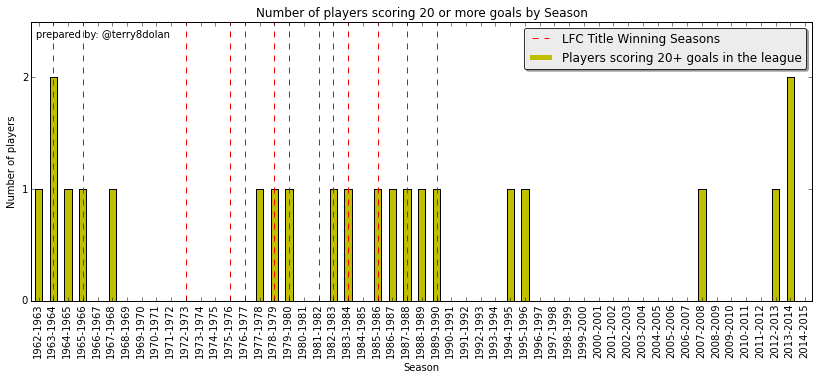

In [50]:
ax = top20_freq.plot(kind='bar', figsize=(14, 5), color='y', yticks=[0, 1, 2], ylim=(0,2.5), grid=False)
ax.set_xlabel('Season')
ax.set_ylabel('Number of players')
ax.set_title('Number of players scoring 20 or more goals by Season')
ax.text(-0.2, 2.36, 'prepared by: @terry8dolan', bbox=dict(facecolor='none', edgecolor='none', alpha=0.6))

# add vertical line for title winning seasons since 1962
champs_since_62 = [list(top20_freq.index.values).index(yr) for yr in CHAMPS if yr[0:4] >= '1962']
for x in champs_since_62:
    plt.axvline(x, color='r', linestyle='--')
    
# create fake legend
l1 = plt.Line2D([], [], linewidth=1, color='r', linestyle='--')
l2 = plt.Line2D([], [], linewidth=5, color='y')
labels = ['LFC Title Winning Seasons', 'Players scoring 20+ goals in the league']
ax.legend([l1, l2], labels, fancybox=True, shadow=True, framealpha=0.8)

# plot and save current figure
fig = plt.gcf() 
plt.show()
fig.savefig('20+PlayervsGoals.png', bbox_inches='tight')

Show percentage of title winning seasons that have had striker with >20 goals

In [51]:
# create a dataframe showing position in league in top flight season since 1962
dflfc_league_pos = dflfc_league[['Season', 'Pos']][dflfc_league.Season.str[0:4] >= '1962']
dflfc_league_pos.rename(columns={'Season': 'season', 'Pos': 'pos'}, inplace=True)
dflfc_league_pos.head()

,season,pos
59,1962-1963,8
60,1963-1964,1
61,1964-1965,7
62,1965-1966,1
63,1966-1967,5


In [52]:
# create dataframe showing position in league when players have scored >20
top20_seasons = dflfc_elite.season.unique()
dflfc_elite_pos = dflfc_league_pos[dflfc_league_pos.season.isin(top20_seasons)]
dflfc_elite_pos.head()

,season,pos
59,1962-1963,8
60,1963-1964,1
61,1964-1965,7
62,1965-1966,1
64,1967-1968,3


In [53]:
# show position in league when players have scored >20
val_cnts = dflfc_league_pos[['season', 'pos']][dflfc_league_pos.season.isin(top20_seasons)]['pos'].value_counts()
val_cnts

1    9
2    4
7    2
4    2
3    2
8    1
dtype: int64

In [54]:
# show % of title winning seasons that have had striker with >20 goals
tot_champs_since_62 = len(dflfc_league_pos[(dflfc_league_pos.pos == 1)])
tot_elite_champs = len(dflfc_elite_pos[(dflfc_elite_pos.pos == 1)])
print '{} of {} ({}%) of title winning seasons have had striker with >20 goals'\
                        .format(tot_elite_champs,
                                tot_champs_since_62,
                                round(100*tot_elite_champs/tot_champs_since_62, 1))

9 of 13 (69.2%) of title winning seasons have had striker with >20 goals


In [55]:
# show the 4 title winning seasons since 1962 that didn't have an elite scorer
dflfc_scorers_tl_pos_age[(dflfc_scorers_tl_pos_age.season.str[0:4] >= '1962') & 
                        (dflfc_scorers_tl_pos_age.season.isin(CHAMPS))].sort(['season', 'league'], ascending=[True, False])\
                        .groupby(dflfc_scorers_tl_pos_age.season).head(1).sort('league').head(4)

,season,player,league,position,age
472,1976-1977,Kevin Keegan,12,Striker,25.9
522,1972-1973,Kevin Keegan,13,Striker,21.9
485,1975-1976,John Toshack,16,Striker,26.8
411,1981-1982,Ian Rush,17,Striker,20.2


In [56]:
# show top goalscorers in modern seasons when Liverpool won the league without a striker scoring >20
s = ['1976-1977', '1972-1973', '1975-1976', '1981-1982']
dflfc_scorers_tl_pos_age[dflfc_scorers_tl_pos_age.season.isin(s)].groupby('season').head(3)

,season,player,league,position,age
411,1981-1982,Ian Rush,17,Striker,20.2
412,1981-1982,Terry McDermott,14,Midfielder,30.1
413,1981-1982,Kenny Dalglish,13,Striker,30.9
472,1976-1977,Kevin Keegan,12,Striker,25.9
473,1976-1977,John Toshack,10,Striker,27.8
474,1976-1977,Steve Heighway,8,Midfielder,29.1
485,1975-1976,John Toshack,16,Striker,26.8
486,1975-1976,Kevin Keegan,12,Striker,24.9
487,1975-1976,David Fairclough,7,Striker,19.0
522,1972-1973,Kevin Keegan,13,Striker,21.9


Show distribution of strikers with more than 20 goals by age

In [57]:
# create 'cut' of value counts
pd.value_counts(pd.cut(dflfc_elite.age.values, range(19,32)))

(26, 27]    4
(25, 26]    4
(24, 25]    3
(29, 30]    2
(27, 28]    2
(30, 31]    1
(28, 29]    1
(23, 24]    1
(22, 23]    1
(21, 22]    1
(20, 21]    1
(19, 20]    1
dtype: int64

In [58]:
# create dataframe of value counts of age cut into 1 year bins from 19 to 31
MIN_AGE = int(np.floor(dflfc_elite.age.min()))
MAX_AGE = int(np.ceil(dflfc_elite.age.max()))

df = pd.DataFrame(pd.value_counts(pd.cut(dflfc_elite.age.values, 
                                         range(MIN_AGE, MAX_AGE+1), 
                                         labels=['{} to {}'.format(i, i+1) for i in range(MIN_AGE, MAX_AGE)])))
df.sort_index(inplace=True)
df

,0
19 to 20,1
20 to 21,1
21 to 22,1
22 to 23,1
23 to 24,1
24 to 25,3
25 to 26,4
26 to 27,4
27 to 28,2
28 to 29,1


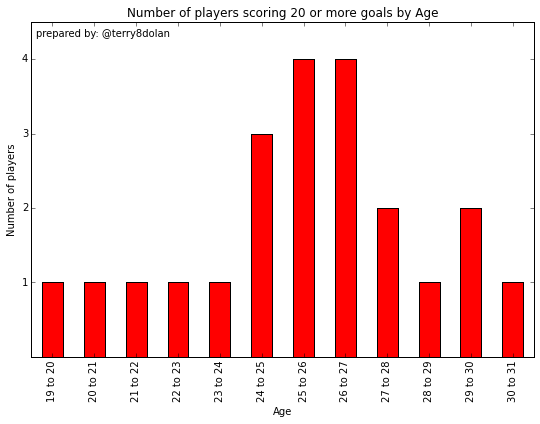

In [59]:
# plot
ax = df.plot(kind='bar', figsize=(9, 6), grid=False, ylim=(0, 4.5), yticks=range(1,5), legend=False, color='r')
ax.set_xlabel('Age')
ax.set_ylabel('Number of players')
ax.set_title('Number of players scoring 20 or more goals by Age')
ax.text(-0.4, 4.3, 'prepared by: @terry8dolan', bbox=dict(facecolor='none', edgecolor='none', alpha=0.6))

# plot and save current figure
fig = plt.gcf() 
plt.show()
fig.savefig('20+PlayervsAge.png', bbox_inches='tight')